In [7]:

# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import pip


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KarthikeyanNatarajan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KarthikeyanNatarajan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KarthikeyanNatarajan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def cleaning(s):
    
    s = str(s)
    #s = str.split(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    s = re.sub(r'https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
    s = re.sub(r'\<a href', ' ', s)
    s = re.sub(r'&amp;', '', s) 
    s = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', s)
    s = re.sub(r'[^\x00-\x7f]',r'',s) #removes arabic
    s = re.sub(r'<br />', ' ', s)
    s = re.sub(r'\'', ' ', s)
    
    return s

train['Question'] = [cleaning(s) for s in train['Question']]

NameError: name 'train' is not defined

In [8]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    nonan = re.compile(r'[^a-zA-Z ]')
    returnString = ""
    sentence_token = tokenize.word_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = nonan.sub('', sentence_token[j])
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        single_sentence=[lemmatizer.lemmatize(t) for t in single_sentence]
        single_sentence = [w for w in single_sentence if not w.isdigit() and not w in stopWords and not w in string.punctuation]
        single_sentence=[word for word in single_sentence if word.lower() not in stopWords]
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' '
    
    return returnString, idx_list



In [9]:
def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each categorie as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

In [156]:
stats

,CODE,QUESTIONS,Category
0,AASKK1,What is Supervised learning?,0
1,AASKK2,What is regression ?,0
2,AASKK3,What is slope ?,0
3,AASKK4,What is intercept ?,0
4,AASKK5,What is semi supervised learning ?,0
5,AASKK6,What is Data split ?,0
6,AASKK7,What do you mean by the training of data ?,0
7,AASKK8,What do you mean by the testing of data ?,0
8,AASKK9,What is the Validation of model ?,0
9,AASKK10,What is Feature Selection ?,0


In [152]:
stats=pd.read_excel('Supervised Learning-Chatbot.xlsx',encoding =  "ISO-8859-1")

In [145]:
stats.columns=["QUESTIONS","Category"]


In [ ]:
stats=stats.dropna(subset=["Question"])

In [162]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
stats["Category"] = labelEncoder.fit_transform(stats["Category"])
stats = stats.rename(columns={'Category': 'Category', 'QUESTIONS': 'Text'})

In [163]:
data_df=stats.sample(frac=1).reset_index(drop=True)

In [164]:
data_df

,CODE,Text,Category
0,AASKK5,What is semi supervised learning ?,0
1,AASKK11,What is Feature scaling ?,0
2,AASKK25,What is ROC or AUC curve ?,1
3,AASKK46,What is Log loss ?,2
4,AASKK30,What is Precision ?,1
5,AASKK38,What is Pearson's correalation coefficient ?,0
6,AASKK27,What is Gradient descent ?,1
7,AASKK10,What is Feature Selection ?,0
8,AASKK31,What is Recall ?,1
9,AASKK45,What is decision Boundary ?,2


In [165]:
articles = []
n = data_df['Text'].shape[0]
col_number = data_df.columns.get_loc('Text')
stopWords = set(stopwords.words('english'))
data_cleaned = data_df.copy()
for i in range(n):
    temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
data_cleaned['Code'] = data_cleaned.Category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

data_cleaned.head()

,CODE,Text,Category,Code
0,AASKK5,semi supervised learning,0,0
1,AASKK11,feature scaling,0,0
2,AASKK25,roc auc curve,1,1
3,AASKK46,log loss,2,2
4,AASKK30,precision,1,1


In [14]:
def cleanData(string1):
    articles = []
    n = 1

    stopWords = set(stopwords.words('english'))
    for i in range(n):
        temp_string,idx_string = cleanString(string1,stopWords)
        articles.append(temp_string)
        print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
    return(articles)

In [166]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""

print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Code',0.85,0.15,0)



{0: 0, 1: 1, 2: 2}
Total:  54
Training:  46 , Percentage:  0.8518518518518519
Validation:  8 , Percentage:  0.14814814814814814
Test: 0 , Percentage:  0.0


In [108]:
def get_vec_pipe(vectorizer_tfidf,num_comp=50, reducer='svd'):  
 
    # Vectorizer
    vec_pipe = [
       #('col_extr', JsonFields(0, ['title', 'body', 'url'])),
       #('squash', Squash()),
       ('vec', vectorizer_tfidf)
    ]

    # Reduce dimensions of tfidf
    if num_comp > 0:
        if reducer == 'svd':
            vec_pipe.append(('dim_red', TruncatedSVD(num_comp)))

        vec_pipe.append(('norm', Normalizer()))

    return Pipeline(vec_pipe)

In [17]:
import csv
import numpy as np
import string
import re
from sklearn.metrics import classification_report,confusion_matrix
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.decomposition import TruncatedSVD

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer,self).build_analyzer()
        return lambda doc:(english_stemmer.stem(word) for word in analyzer(doc))
    
class StemmedCountVectorizer(CountVectorizer):
    def __init__(self, stemmer):
        super(StemmedCountVectorizer, self).__init__()

    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc:(english_stemmer.stem(word) for word in analyzer(doc))

NameError: name 'CountVectorizer' is not defined

In [150]:
import re

from sklearn.pipeline import Pipeline 
def build_tokenizer(doc):
    token_pattern=r"(?u)\b\w+"
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(doc)
posts_root1=[]
for post in train["Text"]:
    #print build_tokenizer(post)
    #print " ".join([english_stemmer.stem(word) for word in build_tokenizer(post)])
    a=" ".join([english_stemmer.stem(word) for word in build_tokenizer(post)])
    posts_root1.append(a)

stem_vectorizer = CountVectorizer(ngram_range=(1,5))


word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words = 'english',
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,1),
    dtype=np.float32,
    max_features=8000
)
# Character Stemmer
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    dtype=np.float32,
    max_features=5000
)

text_clf = Pipeline([('tfidf', stem_vectorizer) ,('vect', vectorizer_tfidf),])
x_tfidf_test=text_clf.fit_transform(posts_root1)


print(x_tfidf_test)

  (0, 30)	0.2581302705303042
  (0, 1)	0.6831430170308235
  (0, 0)	0.6831430170308235
  (1, 127)	0.3479653895249635
  (1, 126)	0.3479653895249635
  (1, 125)	0.3479653895249635
  (1, 42)	0.3479653895249635
  (1, 41)	0.3479653895249635
  (1, 40)	0.26456242815483433
  (1, 33)	0.3479653895249635
  (1, 32)	0.3479653895249635
  (1, 31)	0.26456242815483433
  (1, 30)	0.11159774669239113
  (2, 194)	0.2618155871113128
  (2, 188)	0.1502195792081513
  (2, 175)	0.2151679278832415
  (2, 173)	0.3084632463393842
  (2, 171)	0.28117611494454325
  (2, 168)	0.2151679278832415
  (2, 147)	0.3084632463393842
  (2, 145)	0.28117611494454325
  (2, 144)	0.28117611494454325
  (2, 143)	0.28117611494454325
  (2, 142)	0.20724132432163095
  (2, 17)	0.3084632463393842
  :	:
  (67, 0)	0.3067769876912623
  (68, 193)	0.24594225298112138
  (68, 188)	0.14969846844256257
  (68, 172)	0.30739318929819676
  (68, 171)	0.2802007167887477
  (68, 168)	0.21442151170886248
  (68, 146)	0.30739318929819676
  (68, 145)	0.280200716788747

In [20]:
posts_root1

['string',
 'len function use',
 'draw correl heatmap',
 'python multilin match',
 'differ kind random number panda datafram',
 'creat matrix',
 'whether list mutabl',
 'group number panda',
 'want understand python',
 'mask base column name',
 'creat panda datafram object',
 'python packag',
 'whether key alway uniqu dictionari',
 'convers panda',
 'dictionari dictionari python',
 'plot boxplot normal distribut data',
 'whether python ecosystem well support',
 'purpos oper',
 'generat random number python normal distribut',
 'class python',
 'python dictionari list somehow coupl',
 'file read oper',
 'creat panda seri',
 'data downsampl panda',
 'split two nest list combin part creat two new nest list',
 'indent requir python',
 'outlier boxplot',
 'write list list file',
 'python ad dictionari valu form new dictionari',
 'labelencod panda datafram use sklearn labelencod',
 'select column label',
 'doe mean would use',
 'explain split sub subn method modul python',
 'python librari',


In [94]:
def tokenize_test(model,train,validation,vect,class1):
    from sklearn.decomposition import NMF
    from sklearn.preprocessing import Normalizer
    lsa = TruncatedSVD(n_components=200)
 
    X_train_dtm = vect.fit_transform(train["Text"])
    print ('Features: ', X_train_dtm.shape[1])
    X_test_dtm = vect.transform(validation["Text"])
    #\train_text = lsa.fit_transform(X_train_dtm)
    #test_text = lsa.fit_transform(X_test_dtm)
    train_text = Normalizer(copy=False).fit_transform(X_train_dtm)
    test_text = Normalizer(copy=False).transform(X_test_dtm)
    model.fit(train_text, train["Code"])
    y_pred_class = model.predict(test_text)
    
    print("Training Accuracy")
    print(model.score(train_text,train["Code"]))
    print("Testing Accuracy")
    print(model.score(test_text,validation["Code"]))
    print(classification_report(y_pred_class,validation["Code"]))
    cm = ConfusionMatrix(model, classes=class1)



#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
    cm.score(test_text, validation["Code"])

#How did we do?
    cm.poof()
    #print(confusion_matrix(y_pred_class,validation["Code"]))


In [22]:
from sklearn.preprocessing import Normalizer

In [23]:
def tokenize_test2(model,train,text,vect,class1):
    from sklearn.decomposition import NMF
    from sklearn.preprocessing import Normalizer
    lsa = NMF(n_components=200)
    X_train_dtm = vect.fit_transform(train["Text"])
    print ('Features: ', X_train_dtm.shape[1])
    X_test_dtm = vect.transform(text)
    #train_text = lsa.fit_transform(X_train_dtm)
    #test_text = lsa.fit_transform(X_test_dtm)
    train_text = Normalizer(copy=False).fit_transform(X_train_dtm)
    test_text = Normalizer(copy=False).transform(X_test_dtm)
    model.fit(train_text, train["Code"])
    y_pred_class = model.predict(test_text)
    print(y_pred_class)

Features:  200
Training Accuracy
0.9954128440366973
Testing Accuracy
0.32592592592592595
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.50      0.67      0.57         3
           2       0.27      0.18      0.22        22
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.91      1.00      0.95        10
           6       0.25      0.14      0.18         7
           7       0.33      0.50      0.40         6
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.78      0.70      0.74        10
          11       0.12      0.50      0.20         2
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         3
          15       0.33      0.50      0.40   

C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\yellowbrick\classifier\bas

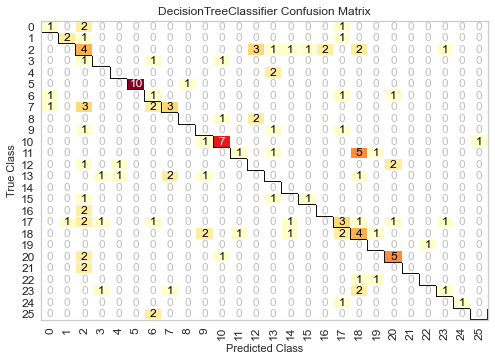

In [57]:
from yellowbrick.classifier import ConfusionMatrix
tokenize_test(DecisionTreeClassifier(),train,validation,get_vec_pipe(text_clf),class1=list(range(0,train["Code"].nunique())))

In [140]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.base import TransformerMixin

Features:  200
Training Accuracy
0.963302752293578
Testing Accuracy
0.6592592592592592
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.50      1.00      0.67         2
           2       0.73      0.42      0.54        26
           3       0.33      1.00      0.50         1
           4       0.00      0.00      0.00         0
           5       0.91      0.91      0.91        11
           6       1.00      1.00      1.00         4
           7       0.78      0.50      0.61        14
           8       0.67      1.00      0.80         2
           9       0.00      0.00      0.00         0
          10       1.00      0.75      0.86        12
          11       0.38      0.50      0.43         6
          12       1.00      1.00      1.00         4
          13       0.50      0.75      0.60         4
          15       0.33      1.00      0.50         1
          16       0.00      0.00      0.00     

C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


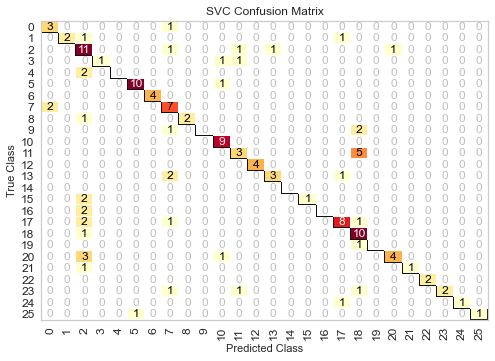

In [58]:
tokenize_test(SVC(kernel = 'linear'),train,validation,get_vec_pipe(text_clf),class1=list(range(0,train["Code"].nunique())))

Features:  200
Training Accuracy
0.9954128440366973
Testing Accuracy
0.6666666666666666
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.50      1.00      0.67         2
           2       0.73      0.52      0.61        21
           3       0.67      0.67      0.67         3
           4       0.00      0.00      0.00         0
           5       1.00      0.85      0.92        13
           6       1.00      1.00      1.00         4
           7       0.78      0.54      0.64        13
           8       0.67      0.67      0.67         3
           9       0.00      0.00      0.00         0
          10       0.89      0.73      0.80        11
          11       0.38      0.60      0.46         5
          12       1.00      1.00      1.00         4
          13       0.50      0.50      0.50         6
          15       0.33      1.00      0.50         1
          16       0.00      0.00      0.00    

C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


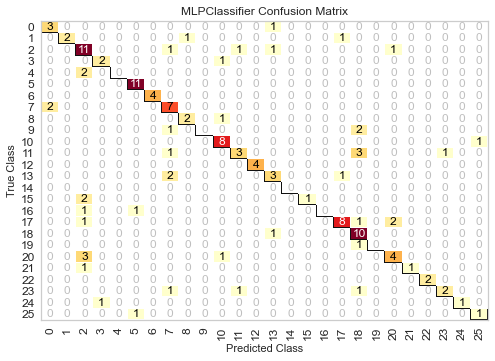

In [59]:
mlp=MLPClassifier(solver = 'lbfgs', alpha = 0.00095, learning_rate = 'adaptive', learning_rate_init = 0.005, max_iter = 300, random_state = 0)
tokenize_test(mlp,train,validation,get_vec_pipe(text_clf),class1=list(range(0,train["Code"].nunique())))

Features:  200
Training Accuracy
0.9954128440366973
Testing Accuracy
0.5259259259259259
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.50      1.00      0.67         2
           2       0.67      0.31      0.43        32
           3       0.33      1.00      0.50         1
           4       0.00      0.00      0.00         0
           5       0.73      0.80      0.76        10
           6       0.75      0.75      0.75         4
           7       0.67      0.38      0.48        16
           8       1.00      0.75      0.86         4
           9       0.00      0.00      0.00         0
          10       0.89      0.62      0.73        13
          11       0.12      0.33      0.18         3
          12       1.00      1.00      1.00         4
          13       0.17      0.50      0.25         2
          14       0.00      0.00      0.00         2
          15       0.33      1.00      0.50    

C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\yellowbrick\classifier\bas

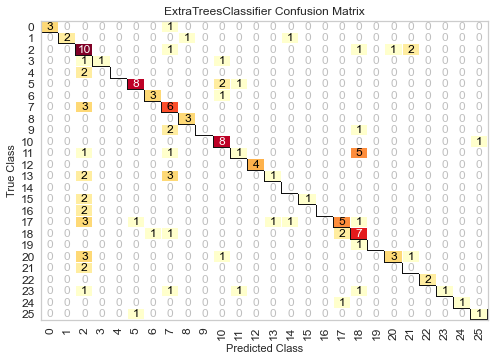

In [67]:
SGD=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='modified_huber',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='none', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False)
tokenize_test(ext,train,validation,get_vec_pipe(text_clf),class1=list(range(0,train["Code"].nunique())))


In [118]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss',
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_freq': 17,
    'learning_rate': 0.1,
    'num_leaves': 63,
    'tree_learner': 'serial',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'output_model': 'LightGBM_model.txt',
    'num_machines': 1,
    'local_listen_port': 12400,
    'machine_list_file': 'mlist.txt',
    'verbose': 0,
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'n_estimators':500
}


Features:  46
Training Accuracy
1.0
Testing Accuracy
0.75
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         0

    accuracy                           0.75         8
   macro avg       0.56      0.56      0.53         8
weighted avg       0.92      0.75      0.80         8



C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


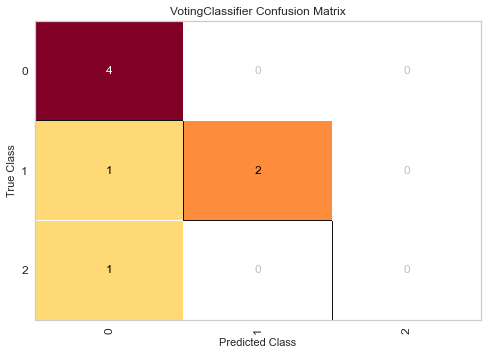

In [167]:
    from sklearn.ensemble import ExtraTreesClassifier
    SVM = SVC(kernel = 'linear', probability = False)
    from sklearn.ensemble import StackingClassifier
    from sklearn.multiclass import OneVsRestClassifier
    from lightgbm import LGBMClassifier
    ext=ExtraTreesClassifier(n_estimators=100, 
                                                       class_weight="balanced", 
                                                       random_state=4621)
    lvc=LinearSVC(class_weight='balanced')
    lda=LinearDiscriminantAnalysis()
    lgbm = LGBMClassifier(
    task = params['task'],
    n_estimators = params['n_estimators'],
    metric = params['metric'],
    tree_learner = params['tree_learner'],
    feature_fraction = params['feature_fraction'],
    bagging_fraction = params['bagging_fraction'],
    bagging_freq = params['bagging_freq'],
    min_data_in_leaf = params['min_data_in_leaf'],
    min_sum_hessian_in_leaf = params['min_sum_hessian_in_leaf'],
    is_enable_sparse = params['is_enable_sparse'],
    use_two_round_loading = params['use_two_round_loading'],
    is_save_binary_file = params['is_save_binary_file'],
    n_jobs = -1
    )
    EnsembleClassifier = VotingClassifier(estimators = [('xgb',xgb),('lgbm',lgbm),('sgd', ext), ('lda',lda),('svc', SVM),('mlp',mlp),('sgd1',SGD)], voting = 'hard', weights = [1,1,1,1,1,1,1])

    tokenize_test(EnsembleClassifier,train,validation,get_vec_pipe(text_clf),class1=list(range(0,train["Code"].nunique())))

In [122]:
from xgboost import XGBClassifier
xgb=XGBClassifier(
     learning_rate =0.1,
     n_estimators=500,
     max_depth=15,
     min_child_weight=12,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'multi:softmax',
     nthread=16,
     scale_pos_weight=1,
     seed=9999,
     num_class= 3,
     eval_metric='merror',    # evaluation metric
     tree_method='exact',
     silent=0, 
     nthreads=-1)

In [38]:
from sklearn.pipeline import FeatureUnion 
from sklearn.model_selection import GridSearchCV

    
text_clf = Pipeline([('union', FeatureUnion([
                              ('tfidf', Pipeline([
                                     
                                       ('vect', StemmedCountVectorizer(english_stemmer)),
                                       ('transform', TfidfVectorizer())
                               ])),
                            ],
                              
                               )),
                              ('clf', SGDClassifier())
                     ])

parameters = [{'union__tfidf__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)), 
            'clf__alpha': (1e-2, 1e-3, 1e-4, 1e-5), 
            'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'), 
            'clf__penalty': ('none', 'l2', 'l1', 'elasticnet'), }]

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(train["Text"],train["Code"])

C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValueError: Invalid parameter ngram_range for estimator StemmedCountVectorizer(stemmer=None). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
from sklearn.model_selection import cross_val_predict
y_predicted = cross_val_predict(gs_clf.best_estimator_, validation["Text"], validation["Code"])

In [ ]:
gs_clf.best_estimator_

In [ ]:
 print(classification_report(y_predicted,validation["Code"]))

In [ ]:
import numpy as np
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt
#vect = CountVectorizer(lowercase=False,stop_words='english')
#vectorizer_tfidf = TfidfVectorizer(lowercase=False,stop_words='english')
# create document-term matrices
X_train_dtm = vectorizer_tfidf.fit_transform(train)
X_test_dtm = vectorizer_tfidf.transform(validation)
u, s, v = randomized_svd(X_train_dtm, 250)

In [ ]:
# computes an orthonormal matrix whose range approximates the range of A
# power_iteration_normalizer can be safe_sparse_dot (fast but unstable), LU (imbetween), or QR (slow but most accurate)
def randomized_range_finder(A, size, n_iter=5):
    Q = np.random.normal(size=(A.shape[1], size))
    
    for i in range(n_iter):
        Q, _ = linalg.lu(A @ Q, permute_l=True)
        Q, _ = linalg.lu(A.T @ Q, permute_l=True)
        
    Q, _ = linalg.qr(A @ Q, mode='economic')
    return Q

In [ ]:
def randomized_svd(M, n_components, n_oversamples=10, n_iter=4):
    
    n_random = n_components + n_oversamples
    
    Q = randomized_range_finder(M, n_random, n_iter)
    
    # project M to the (k + p) dimensional space using the basis vectors
    B = Q.T @ M
    
    # compute the SVD on the thin matrix: (k + p) wide
    Uhat, s, V = linalg.svd(B, full_matrices=False)
    del B
    U = Q @ Uhat
    
    return U[:, :n_components], s[:n_components], V[:n_components, :]

In [ ]:
print (len(vectorizer_tfidf.get_feature_names()[:]))

In [ ]:
show_topics(svd)

In [ ]:
num_top_words=50
vocab = np.array(vectorizer_tfidf.get_feature_names())

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    print(len(vocab))
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]